<center><h1><b> Modeling and Simulation of Customer Traffic in a Cafe</h1> </center>

<h2> Project Overview</b> </h2>
<h5> This project aims to predict the peak hours for sales at a supposed cafe based on various factors. The goal of this project is to focus on modeling and simulation using Python by generating synthetic data and applying machine learning models. The goal is to gain hands-on experience with various libraries.

In [1]:
# Import the necessary frameworks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

<b><h3> Data Generation </h3></b>
This project will use synthetic data to simulate various aspects of a cafe's operation.
<h4> <b> - Distributions 

In [2]:
n_samples = 1000

# setting a random seed so we can reproduce the same results every time
np.random.seed(42)

# generate Time of Day
time_of_day = np.random.choice(['Morning', 'Afternoon', 'Evening'], 
                               size=n_samples, 
                               p=[0.35, 0.32, 0.33]) # almost busy everytime

# generate Day of the Week 
day_of_week = np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                                size=n_samples, 
                                p=[0.15, 0.1, 0.1, 0.1, 0.225, 0.225, 0.1]) # all days have more traffic except monnday, friday and saturday are a bit busier

# generate Weather 
weather = np.random.choice(['Sunny', 'Rainy', 'Cloudy'], 
                           size=n_samples, 
                           p=[0.5, 0.2, 0.3])

# Generate Promotion Status 
promotion = np.random.choice(['Yes', 'No'], 
                             size=n_samples, 
                             p=[0.2, 0.8]) # 20% chance of a promotion being active

# Generate Special Events 
special_event = np.random.choice(['Yes', 'No'], 
                                 size=n_samples, 
                                 p=[0.1, 0.9]) # 10% chance of a speial event being active

<h4><b> - Correlations

In [3]:
# base traffic/customers will depend on time of the day
base_traffic = np.array([50 if t == 'Morning' else 80 if t == 'Afternoon' else 40 for t in time_of_day])

# sunny weather increases traffic by 10, and if rainy, decreases by 20
weather_impact = np.array([10 if w == 'Sunny' else -20 if w == 'Rainy' else 0 for w in weather])

# promotion impact on traffic increases by 20
promotion_impact = np.array([20 if p == 'Yes' else 0 for p in promotion])

# special events increases traffic by 30
event_impact = np.array([30 if e == 'Yes' else 0 for e in special_event])

# add noise to data generated
random_noise = np.random.normal(0, 6, size=n_samples)

# Total traffic
customer_traffic = base_traffic + weather_impact + promotion_impact + event_impact + random_noise
customer_traffic = np.clip(customer_traffic, 0, None).astype(int)  # Ensure no negative traffic

# Combine into a DataFrame
data = pd.DataFrame({
    'Time of Day': time_of_day,
    'Day of Week': day_of_week,
    'Weather': weather,
    'Promotion': promotion,
    'Special Event': special_event,
    'Customer Traffic': customer_traffic
})

data.to_csv('cafe_traffic_data.csv', index=False)

print(data)

    Time of Day Day of Week Weather Promotion Special Event  Customer Traffic
0     Afternoon     Tuesday   Sunny        No            No                86
1       Evening      Friday   Sunny        No            No                35
2       Evening    Saturday  Cloudy        No            No                37
3     Afternoon    Saturday   Sunny        No            No                95
4       Morning    Saturday   Sunny        No            No                63
..          ...         ...     ...       ...           ...               ...
995     Morning      Friday  Cloudy        No            No                57
996     Evening      Sunday   Sunny        No            No                55
997     Morning      Monday   Sunny        No            No                51
998     Evening      Monday   Sunny        No            No                53
999   Afternoon   Wednesday  Cloudy       Yes            No                98

[1000 rows x 6 columns]


<h3><b>EDA on the generated data </h3>

<b><h4> - Check dataset and data statistics</h4>

In [4]:
# call our dataset
data = pd.read_csv('cafe_traffic_data.csv')

print(data.info())  # Check data types and missing values
print(data.describe()) # check key metrics 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Time of Day       1000 non-null   object
 1   Day of Week       1000 non-null   object
 2   Weather           1000 non-null   object
 3   Promotion         1000 non-null   object
 4   Special Event     1000 non-null   object
 5   Customer Traffic  1000 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 47.0+ KB
None
       Customer Traffic
count       1000.000000
mean          63.886000
std           24.268992
min            1.000000
25%           47.000000
50%           61.500000
75%           84.000000
max          140.000000


<h4><b>- Plot distributions </h4>

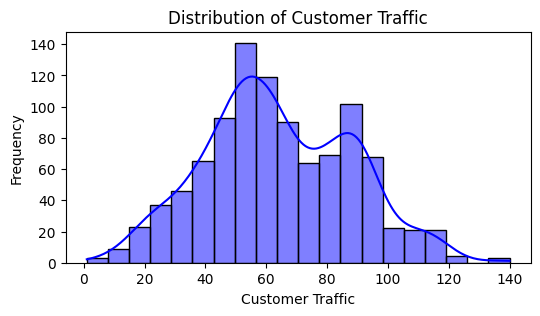

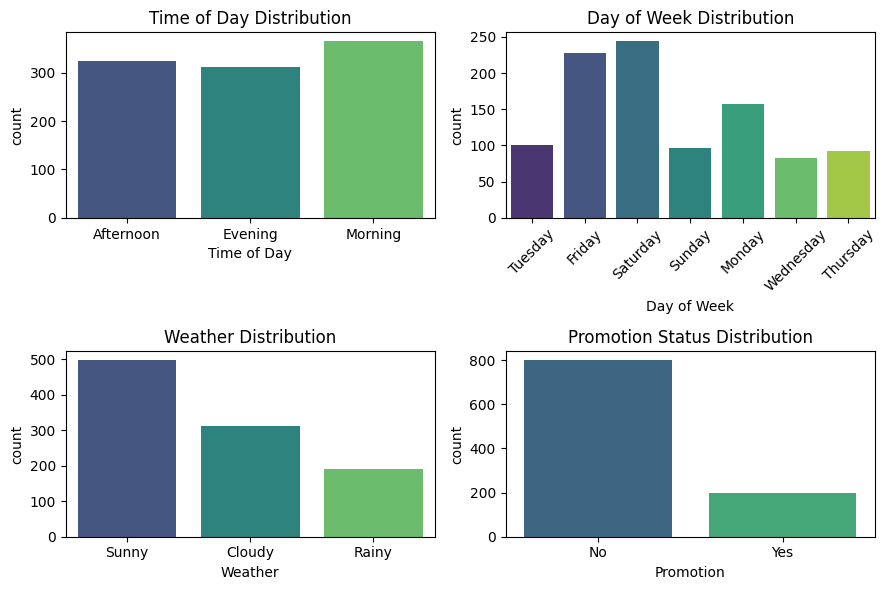

In [5]:
# plot distributions of Customer Traffic
plt.figure(figsize=(6, 3))
sns.histplot(data['Customer Traffic'], kde=True, bins=20, color='blue')
plt.title('Distribution of Customer Traffic')
plt.xlabel('Customer Traffic')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(9, 6))

plt.subplot(2, 2, 1)
sns.countplot(data=data, x='Time of Day', palette='viridis', hue='Time of Day', legend=False)
plt.title('Time of Day Distribution')

# Day of Week Distribution
plt.subplot(2, 2, 2)
sns.countplot(data=data, x='Day of Week', palette='viridis', hue='Day of Week', legend=False)
plt.title('Day of Week Distribution')
plt.xticks(rotation=45)

# Weather Distribution
plt.subplot(2, 2, 3)
sns.countplot(data=data, x='Weather', palette='viridis', hue='Weather', legend=False)
plt.title('Weather Distribution')

# Promotion Status Distribution
plt.subplot(2, 2, 4)
sns.countplot(data=data, x='Promotion', palette='viridis', hue='Promotion', legend=False)
plt.title('Promotion Status Distribution')

plt.tight_layout()
plt.show()

<h4><b>- Plot correlations and heatmap</h4>

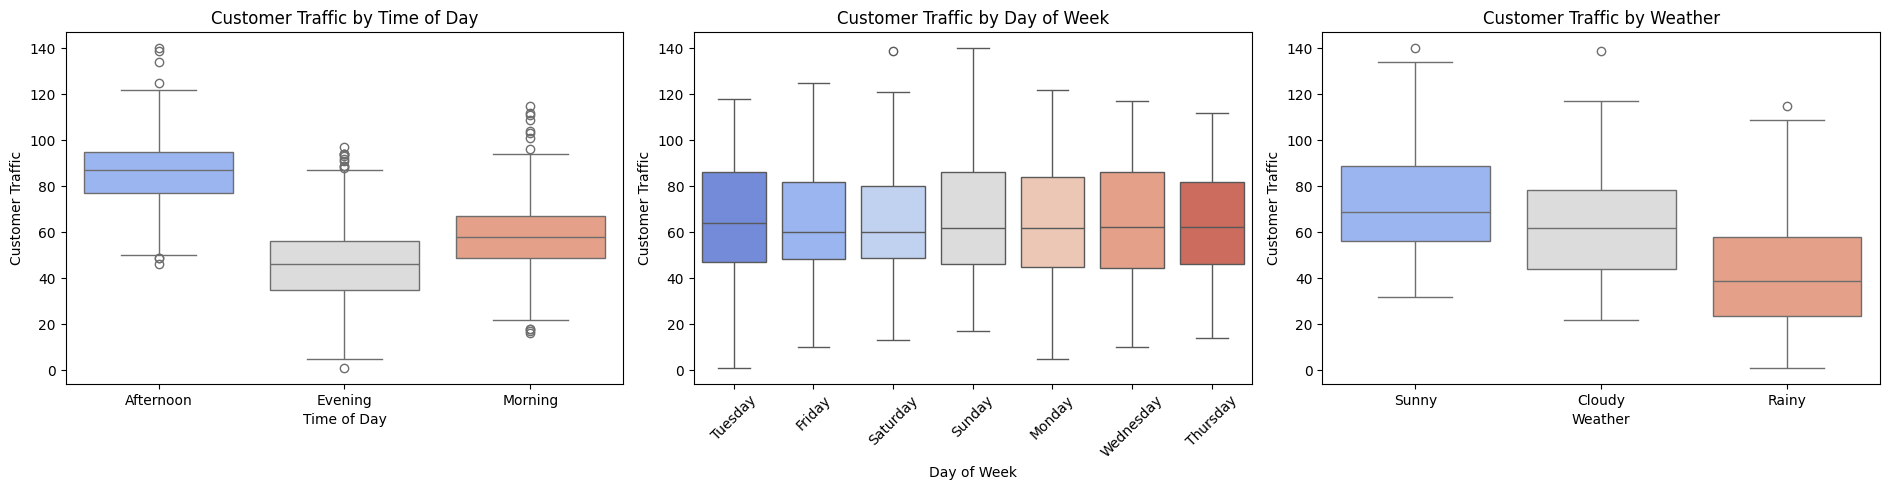

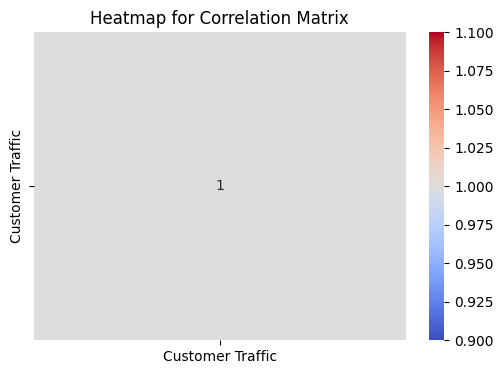

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(19, 5))

# 1. Boxplot to analyze Customer Traffic vs. Time of Day
sns.boxplot(x='Time of Day', y='Customer Traffic', data=data, hue='Time of Day', palette='coolwarm', ax=axes[0], legend=False)
axes[0].set_title('Customer Traffic by Time of Day')

# 2. Boxplot to analyze Customer Traffic vs. Day of Week
sns.boxplot(x='Day of Week', y='Customer Traffic', data=data, hue='Day of Week', palette='coolwarm', ax=axes[1], legend=False)
axes[1].set_title('Customer Traffic by Day of Week')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# 3. Analyzing Weather and its impact on Customer Traffic
sns.boxplot(x='Weather', y='Customer Traffic', data=data, hue='Weather', palette='coolwarm', ax=axes[2], legend=False)
axes[2].set_title('Customer Traffic by Weather')

plt.tight_layout()
plt.show()

# Separate heatmap for correlation matrix
plt.figure(figsize=(6, 4))
correlation_data = data[['Customer Traffic']]
correlation_matrix = correlation_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap for Correlation Matrix')
plt.show()

<h3><b>Data Modeling and Simulation </h3>

<h5> This section provides a systematic pipeline for data modeling and simulation of customer traffic predictions.


Scenario 1:
Time of Day: Morning, Day of Week: Monday, Weather: Sunny, Promotion: Yes, Special Event: Yes
Predicted Customer Traffic: 109
Reasoning: Morning with sunny weather usually attracts more traffic.

Scenario 2:
Time of Day: Morning, Day of Week: Tuesday, Weather: Sunny, Promotion: No, Special Event: No
Predicted Customer Traffic: 60
Reasoning: Morning with sunny weather usually attracts more traffic.

Scenario 3:
Time of Day: Afternoon, Day of Week: Wednesday, Weather: Cloudy, Promotion: Yes, Special Event: Yes
Predicted Customer Traffic: 129
Reasoning: Active promotions generally increase traffic.

Scenario 4:
Time of Day: Afternoon, Day of Week: Thursday, Weather: Rainy, Promotion: No, Special Event: No
Predicted Customer Traffic: 59
Reasoning: Rainy weather typically reduces customer traffic.

Scenario 5:
Time of Day: Evening, Day of Week: Friday, Weather: Sunny, Promotion: Yes, Special Event: No
Predicted Customer Traffic: 69
Reasoning: Active promotions generally increase

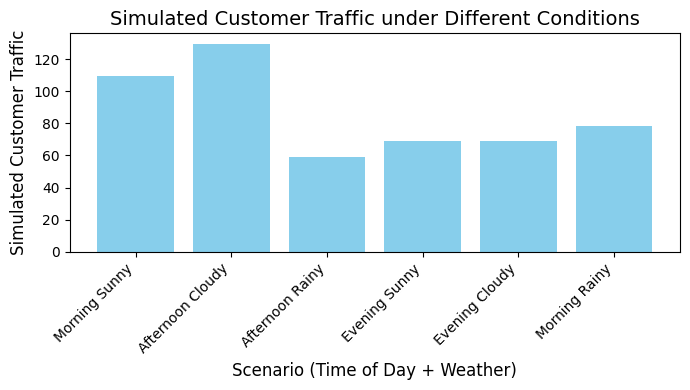

Mean Absolute Error (MAE): 4.795085634157022
Mean Squared Error (MSE): 38.937220364793404
R² (R-squared): 0.9355907055173197



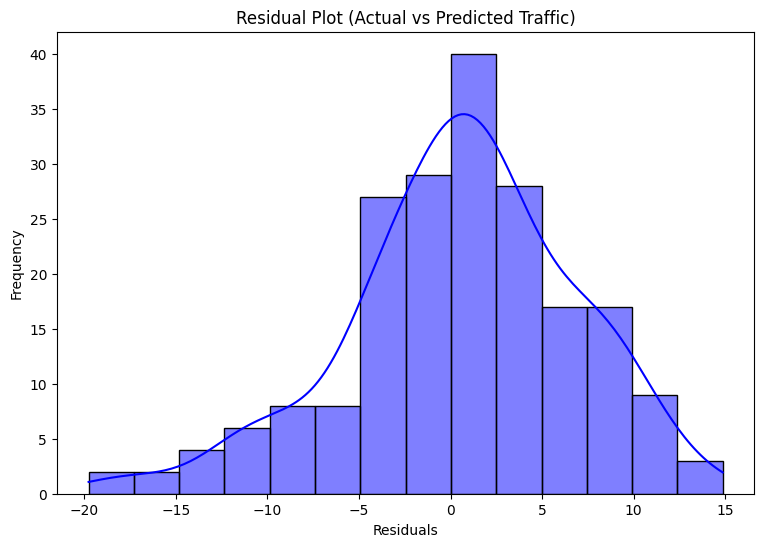

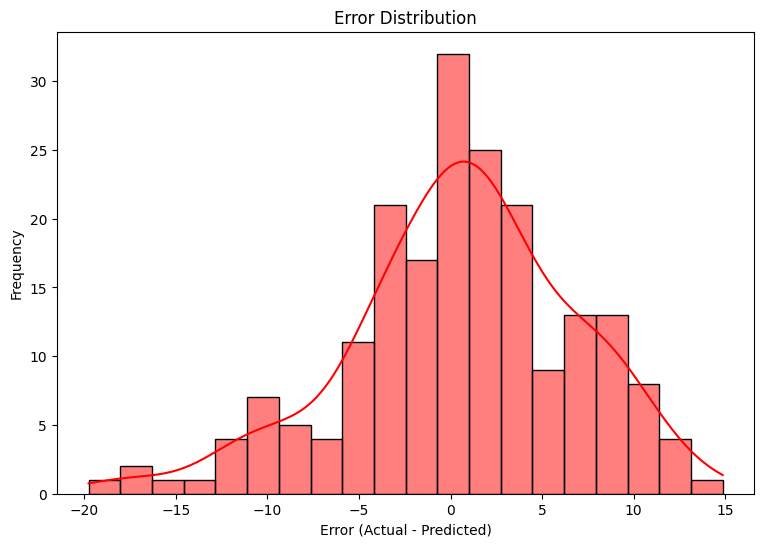

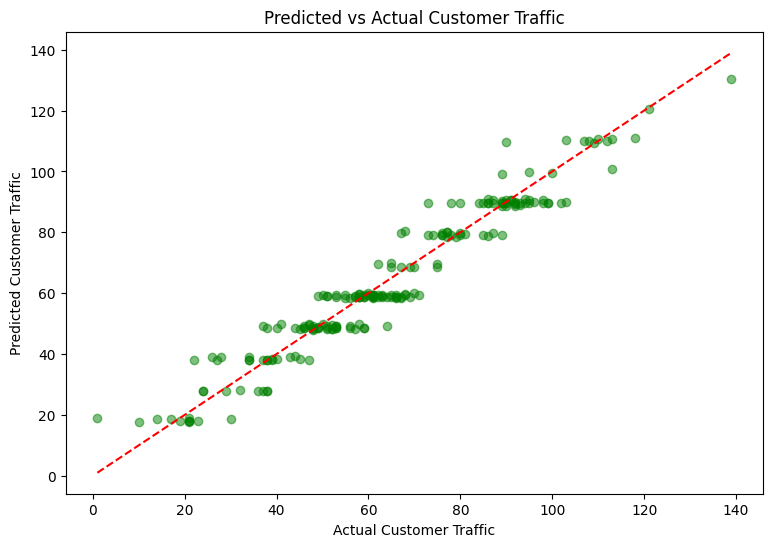

In [7]:
# Function to preprocess data
def preprocess_data(data):
    X = data[['Time of Day', 'Day of Week', 'Weather', 'Promotion', 'Special Event']]
    y = data['Customer Traffic']
    
    # Define the column transformer for one-hot encoding
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), ['Time of Day', 'Day of Week', 'Weather', 'Promotion', 'Special Event'])
        ])
    
    return X, y, preprocessor

# Function to create and train the model
def train_model(X_train, y_train, preprocessor):
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    model.fit(X_train, y_train)
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mae, mse, r2

# Function to simulate customer traffic under given conditions
def simulate_traffic(model, conditions):
    simulated_traffic = model.predict(conditions)
    return simulated_traffic[0]

# Function to create simulation scenarios
def create_simulation_scenarios():
    scenarios = [
        ('Morning', 'Monday', 'Sunny', 'Yes', 'Yes'),
        ('Morning', 'Tuesday', 'Sunny', 'No', 'No'),
        ('Afternoon', 'Wednesday', 'Cloudy', 'Yes', 'Yes'),
        ('Afternoon', 'Thursday', 'Rainy', 'No', 'No'),
        ('Evening', 'Friday', 'Sunny', 'Yes', 'No'),
        ('Evening', 'Saturday', 'Cloudy', 'No', 'Yes'),
        ('Morning', 'Sunday', 'Rainy', 'Yes', 'Yes')
    ]
    
    # Convert to a DataFrame
    simulation_df = pd.DataFrame(scenarios, columns=['Time of Day', 'Day of Week', 'Weather', 'Promotion', 'Special Event'])
    return simulation_df

# Function to simulate customer traffic for each scenario and print results
def run_simulation(model, simulation_df):
    simulated_traffic = []
    
    for idx, scenario in simulation_df.iterrows():
        # Convert the current scenario to the same format as the training data
        scenario_data = scenario.to_frame().T  # Convert row to dataframe
        
        # Ensure the data is preprocessed as it was during training (via the pipeline)
        scenario_data_transformed = model.named_steps['preprocessor'].transform(scenario_data)
        
        # Simulate traffic for the scenario
        traffic = model.named_steps['regressor'].predict(scenario_data_transformed)
        simulated_traffic.append(traffic[0])
        
        # Print detailed output for the viewer
        print(f"Scenario {idx + 1}:")
        print(f"Time of Day: {scenario['Time of Day']}, Day of Week: {scenario['Day of Week']}, Weather: {scenario['Weather']}, "
              f"Promotion: {scenario['Promotion']}, Special Event: {scenario['Special Event']}")
        print(f"Predicted Customer Traffic: {traffic[0]:.0f}")
        
        # Reasoning for prediction
        reasoning = "Traffic is expected to be moderate."
        
        # Customize reasoning based on the scenario conditions
        if scenario['Time of Day'] == 'Morning' and scenario['Weather'] == 'Sunny':
            reasoning = "Morning with sunny weather usually attracts more traffic."
        elif scenario['Weather'] == 'Rainy':
            reasoning = "Rainy weather typically reduces customer traffic."
        elif scenario['Promotion'] == 'Yes':
            reasoning = "Active promotions generally increase traffic."
        elif scenario['Special Event'] == 'Yes':
            reasoning = "Special events tend to increase traffic significantly."
        
        print(f"Reasoning: {reasoning}\n")
    
    # Return the simulated traffic for all scenarios
    simulation_df['Simulated Traffic'] = simulated_traffic
    return simulation_df

# Function to visualize simulation results
def visualize_simulation(simulation_df):
    plt.figure(figsize=(7, 4))
    # Create a bar plot showing the impact of different scenarios
    plt.bar(simulation_df['Time of Day'] + ' ' + simulation_df['Weather'], simulation_df['Simulated Traffic'], color='skyblue')
    
    plt.xlabel('Scenario (Time of Day + Weather)', fontsize=12)
    plt.ylabel('Simulated Customer Traffic', fontsize=12)
    plt.title('Simulated Customer Traffic under Different Conditions', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Function to visualize model evaluation results
def visualize_evaluation_results(y_test, y_pred):
    plt.figure(figsize=(9, 6))
    # Residual plot
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, color='blue')
    plt.title('Residual Plot (Actual vs Predicted Traffic)')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Error distribution plot (Histogram of errors)
    plt.figure(figsize=(9, 6))
    sns.histplot(y_test - y_pred, kde=True, color='red', bins=20)
    plt.title('Error Distribution')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.show()

    # Predicted vs Actual Plot
    plt.figure(figsize=(9, 6))
    plt.scatter(y_test, y_pred, color='green', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title('Predicted vs Actual Customer Traffic')
    plt.xlabel('Actual Customer Traffic')
    plt.ylabel('Predicted Customer Traffic')
    plt.show()

def main():
    # Preprocess data
    X, y, preprocessor = preprocess_data(data)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = train_model(X_train, y_train, preprocessor)

    # Predict the traffic on the test set
    y_pred = model.predict(X_test)

    # Create simulation scenarios
    simulation_df = create_simulation_scenarios()

    # Run the simulation and print the results
    simulation_results = run_simulation(model, simulation_df)

    # Visualize the simulation results
    visualize_simulation(simulation_results)
    # Evaluate the model
    mae, mse, r2 = evaluate_model(model, X_test, y_test)
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R² (R-squared): {r2}\n")

    # Visualize model evaluation results
    visualize_evaluation_results(y_test, y_pred)

# Run the main function
if __name__ == "__main__":
    main()
